## feeder concept: cutter + barges

This notebook shows how to implement a basic feeder concept for a cutter suction dredge working with multiple barges.

In [1]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd

import openclsim.core as core
import openclsim.model as model
from openclsim.utils import flatten
from openclsim.plot import get_step_chart, get_gantt_chart
import numpy as np

In [2]:
cutter_name    = 'Cutter T'
barge_names    = ['Carrier A','Carrier B','Carrier C',
                  'Barge I','Barge II','Barge III',
                  'Extra 1', 'Extra 2', 'Extra 3']
vessel_cost     = {'Carrier A':6000,'Carrier B':6000,'Carrier C':6000,
                  'Barge I':5000,'Barge II':5000,'Barge III':5000,
                  'Extra 1':4000, 'Extra 2':4000, 'Extra 3':4000,
                  'Cutter T':25000} # EUR/day
# vessel_amount and vessel_durations are random within a range,
# to mimic respectively material density variations
# and metocean workability conditions and traffic density.

amount_range = [4,6]
duration_range = [2000,3000]

from_site_name = 'Trench'
to_site_name   = 'Reclamation'

In [3]:
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
    ),
    {},
)

In [4]:
def run(NR_BARGES, total_amount):
    simulation_start = 0
    my_env = simpy.Environment(initial_time=simulation_start)
    registry = {}

    location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
    location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)

    data_from_site = {"env": my_env,
                      "name": from_site_name,
                      "geometry": location_from_site,
                      "capacity": total_amount,
                      "level": total_amount,
                      "nr_resources":1
                     }
    from_site = Site(**data_from_site)

    location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
    data_to_site = {"env": my_env,
                    "name": to_site_name,
                    "geometry": location_to_site,
                    "capacity": total_amount,
                    "level": 0,
                    "nr_resources":4
                   }
    to_site = Site(**data_to_site)

    vessels = {}

    for i in range(NR_BARGES):
        vessel_name = barge_names[i]
        vessels[vessel_name] = TransportProcessingResource(
            env=my_env,
            name=vessel_name,
            geometry=location_from_site, 
            capacity=10,
            compute_v=lambda x: 10
        )
    cutter = TransportProcessingResource(
        env=my_env,
        name=cutter_name,
        geometry=location_from_site, 
        capacity=10,
        compute_v=lambda x: 10
    )
    vessels[cutter_name] = cutter
    

    activities = {}
    for i in range(NR_BARGES):
        vessel_name = barge_names[i]
        amount = np.random.randint(amount_range[0], amount_range[1]) # handle loading
        duration=np.random.randint(duration_range[0], duration_range[1]) # sailing and unloading

        requested_resources={}
        activities[f"activity{i}"] = model.WhileActivity(
            env=my_env,
            name=f"while_sequential_activity_subcycle {vessel_name}",
            registry=registry,
            sub_processes=[model.SequentialActivity(
                env=my_env,
                name=f"sequential_activity_subcycle {vessel_name}",
                registry=registry,
                sub_processes=[
                    model.BasicActivity(
                        env=my_env,
                        name=f"basic activity:"+vessels[vessel_name].name,
                        registry=registry,
                        duration=duration,
                        additional_logs=[vessels[vessel_name]],
                    ),
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing empty:"+vessels[vessel_name].name,
                        registry=registry,
                        mover=vessels[vessel_name],
                        destination=from_site,
                        duration=duration,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"loading:"+vessels[vessel_name].name,
                        registry=registry,
                        processor=cutter,
                        origin=from_site,
                        destination=vessels[vessel_name],
                        amount=amount,
                        duration=500*amount,
                        requested_resources=requested_resources,
                    ),
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing full:"+vessels[vessel_name].name,
                        registry=registry,
                        mover=vessels[vessel_name],
                        destination=to_site,
                        duration=duration,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"unloading:"+vessels[vessel_name].name,
                        registry=registry,
                        processor=vessels[vessel_name],
                        origin=vessels[vessel_name],
                        destination=to_site,
                        amount=amount,
                        duration=duration,
                        requested_resources=requested_resources,
                    ),
                ],
            )],
            condition_event=[
                {
                    "type": "container", 
                    "concept": to_site, 
                    "state": "full",
                    "id_":"default_reservations"
                }
            ],
        )

    model.register_processes(list(activities.values()))
    my_env.run()
    
    return {
        "vessels": vessels,
        "activities":activities,
        from_site_name:from_site,
        to_site_name:to_site,
    }


# Example plots with 3 barges

In [5]:
%%time
nbarges = len(barge_names)
assert len(set(barge_names))==len(barge_names), 'barge_names need to be unique'
total_amount = 100
res = run(3,total_amount)
vessels = res['vessels']
activities = res['activities']
cutter = vessels[cutter_name]
to_site = res[to_site_name]
from_site = res[from_site_name]

CPU times: user 76.6 ms, sys: 13.2 ms, total: 89.8 ms
Wall time: 100 ms


In [6]:
fig = get_gantt_chart(vessels, id_map=activities)


In [7]:
fig = get_gantt_chart([from_site, to_site, cutter], id_map=activities)

Plot only activities whose namespace (first letters) matches load*

In [8]:
flat = pd.DataFrame(flatten(activities))
loading = list(flat[flat['ActivityName'].str.startswith('loading')]['activity'].values)
fig = get_gantt_chart(loading)

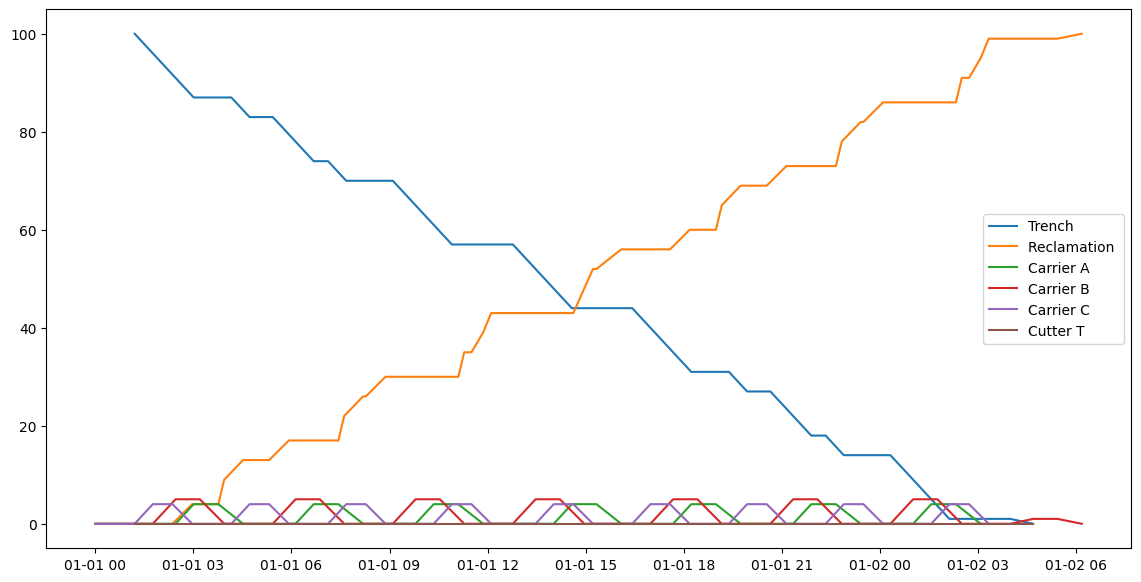

In [9]:
fig = get_step_chart([from_site, to_site, *vessels.values()])

# Compare multiple barge scenarios

In [10]:
def occupancy_analysis(vessels, cutter, activities, vessel_cost):
    data = []
    duration_theory_cutter = 0
    nr_trips_cutter = 0

    # barges
    for i, vessel_name in enumerate(vessels):
        if vessel_name!=cutter_name:
            vessel = vessels[vessel_name]
            activity = activities[f'activity{i}']

            log = pd.DataFrame(vessel.log)
            sub_act = activity.sub_processes[0].sub_processes[-1] # last phase of SequentialActivity ..
            nr_trips = len(log[(log.ActivityID == sub_act.id) & (log.ActivityState == "STOP")]) # .. ended
            nr_trips_cutter += nr_trips

            duration_theory = 0
            for sub_act in activity.sub_processes[0].sub_processes:
                duration_theory+=sub_act.duration
                if hasattr(sub_act,'processor'):
                    if sub_act.processor.name==cutter_name:
                        duration_theory_cutter += sub_act.duration*nr_trips

            duration_actual = (log.Timestamp.max() - log.Timestamp.min()).total_seconds()
            data.append({
                'name':vessel.name, 
                '# trips':nr_trips, 
                'start': log.Timestamp.min(),
                'finish': log.Timestamp.max(),
                'duration actual': duration_actual,
                'cost':duration_actual*vessel_cost[vessel_name]/3600/24,
                'production actual':(nr_trips * sub_act.amount) / (duration_actual),
                'production theory': (sub_act.amount / (duration_theory)),
            })

    # cutter
    log = pd.DataFrame(cutter.log)
    duration_actual_cutter = (log.Timestamp.max() - log.Timestamp.min()).total_seconds()
    data.append({
        'name':cutter_name, 
        '# trips':nr_trips_cutter, 
        'start': log.Timestamp.min(),
        'finish': log.Timestamp.max(),
        'duration actual': duration_actual_cutter,
        'cost':duration_actual_cutter*vessel_cost[cutter_name]/3600/24,
        'production actual':(total_amount) / (duration_actual_cutter),
        'production theory':(total_amount) / (duration_theory_cutter),
    })

    df = pd.DataFrame(data).sort_values(by=['production actual'],ascending=False)
    df['occupancy [%]'] = [round(x,1) for x in 100*df['production actual']/df['production theory']]
    df.set_index('name', inplace=True)
    
    print(f'Occupancy "{cutter_name}":', df.loc[cutter_name]['occupancy [%]'],'% Total cost',round(df['cost'].sum(),0))
    
    return df

In [11]:
results = []
occupancy = []
cost = []
finish, duration = [], []
n_barges = range(2,len(barge_names)) # +1 at least 1 barge
for i in n_barges:
    results.append(run(i,total_amount))
    vessels = results[-1]['vessels']
    activities = results[-1]['activities']
    cutter = vessels[cutter_name]
    to_site = results[-1][to_site_name]
    from_site = results[-1][from_site_name]
    df = occupancy_analysis(vessels, cutter, activities,vessel_cost)
    occupancy.append(df.loc[cutter_name]['occupancy [%]'])
    cost.append(df['cost'].sum())
    finish.append(df['finish'].max())
    duration.append((df['finish'].max() - df['start'].min()).total_seconds()/3600/24)
    display(df)

Occupancy "Cutter T": 31.8 % Total cost 68662.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,25,1970-01-01 01:24:54,1970-01-02 21:05:22,157228.0,45494.212963,0.000636,0.002000,31.8
Carrier B,13,1970-01-01 00:00:00,1970-01-02 22:30:16,167416.0,11626.111111,0.000311,0.000328,94.6
Carrier A,12,1970-01-01 00:00:00,1970-01-02 22:09:56,166196.0,11541.388889,0.000289,0.000291,99.3


Occupancy "Cutter T": 50.2 % Total cost 50247.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,25,1970-01-01 01:15:36,1970-01-02 04:56:48,99672.0,28840.277778,0.001003,0.002000,50.2
Carrier A,9,1970-01-01 00:00:00,1970-01-02 03:57:40,100660.0,6990.277778,0.000358,0.000361,99.0
Carrier C,8,1970-01-01 00:00:00,1970-01-02 03:10:34,97834.0,6794.027778,0.000327,0.000349,93.6
Carrier B,8,1970-01-01 00:00:00,1970-01-02 06:29:18,109758.0,7622.083333,0.000292,0.000305,95.5


Occupancy "Cutter T": 75.4 % Total cost 39208.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,23,1970-01-01 01:08:02,1970-01-01 20:17:22,68960.0,19953.703704,0.001450,0.001923,75.4
Carrier C,6,1970-01-01 00:00:00,1970-01-01 19:24:04,69844.0,4850.277778,0.000430,0.000446,96.4
Carrier A,6,1970-01-01 00:00:00,1970-01-01 21:39:48,77988.0,5415.833333,0.000385,0.000403,95.3
Carrier B,6,1970-01-01 00:00:00,1970-01-01 18:32:12,66732.0,4634.166667,0.000360,0.000394,91.4
Barge I,5,1970-01-01 00:00:00,1970-01-01 20:53:52,75232.0,4353.703704,0.000266,0.000301,88.4


Occupancy "Cutter T": 82.3 % Total cost 39201.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,23,1970-01-01 01:29:48,1970-01-01 18:32:32,61364.0,17755.787037,0.001630,0.001980,82.3
Carrier B,5,1970-01-01 00:00:00,1970-01-01 20:06:00,72360.0,5025.000000,0.000345,0.000365,94.8
Barge II,4,1970-01-01 00:00:00,1970-01-01 17:40:06,63606.0,3680.902778,0.000314,0.000361,87.1
Carrier C,5,1970-01-01 00:00:00,1970-01-01 18:08:40,65320.0,4536.111111,0.000306,0.000313,97.8
Carrier A,5,1970-01-01 00:00:00,1970-01-01 18:46:12,67572.0,4692.500000,0.000296,0.000304,97.3
Barge I,4,1970-01-01 00:00:00,1970-01-01 16:51:12,60672.0,3511.111111,0.000264,0.000301,87.5


Occupancy "Cutter T": 98.3 % Total cost 35591.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,24,1970-01-01 01:08:56,1970-01-01 15:16:44,50868.0,14718.750000,0.001966,0.002000,98.3
Barge I,4,1970-01-01 00:00:00,1970-01-01 14:56:06,53766.0,3111.458333,0.000372,0.000416,89.5
Barge II,5,1970-01-01 00:00:00,1970-01-01 16:25:40,59140.0,3422.453704,0.000338,0.000389,86.8
Carrier C,4,1970-01-01 00:00:00,1970-01-01 13:39:48,49188.0,3415.833333,0.000325,0.000352,92.4
Carrier A,4,1970-01-01 00:00:00,1970-01-01 15:30:00,55800.0,3875.000000,0.000287,0.000345,83.1
Carrier B,4,1970-01-01 00:00:00,1970-01-01 16:05:48,57948.0,4024.166667,0.000276,0.000336,82.1
Barge III,3,1970-01-01 00:00:00,1970-01-01 14:30:46,52246.0,3023.495370,0.000230,0.000297,77.4


Occupancy "Cutter T": 100.0 % Total cost 36895.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,22,1970-01-01 01:07:02,1970-01-01 15:08:42,50500.0,14612.268519,0.001980,0.001980,100.0
Carrier C,4,1970-01-01 00:00:00,1970-01-01 15:42:24,56544.0,3926.666667,0.000354,0.000474,74.6
Carrier A,3,1970-01-01 00:00:00,1970-01-01 13:06:14,47174.0,3275.972222,0.000318,0.000463,68.7
Barge III,3,1970-01-01 00:00:00,1970-01-01 13:48:18,49698.0,2876.041667,0.000302,0.000461,65.5
Barge II,3,1970-01-01 00:00:00,1970-01-01 15:21:24,55284.0,3199.305556,0.000271,0.000384,70.7
Carrier B,3,1970-01-01 00:00:00,1970-01-01 12:23:52,44632.0,3099.444444,0.000269,0.000391,68.7
Extra 1,3,1970-01-01 00:00:00,1970-01-01 14:33:02,52382.0,2425.092593,0.000229,0.000341,67.1
Barge I,3,1970-01-01 00:00:00,1970-01-01 16:42:16,60136.0,3480.092593,0.000200,0.000302,66.0


Occupancy "Cutter T": 100.0 % Total cost 38549.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,21,1970-01-01 01:10:16,1970-01-01 15:03:36,50000.0,14467.592593,0.002000,0.002000,100.0
Barge III,3,1970-01-01 00:00:00,1970-01-01 13:02:12,46932.0,2715.972222,0.000320,0.000457,69.9
Barge I,3,1970-01-01 00:00:00,1970-01-01 14:20:42,51642.0,2988.541667,0.000290,0.000440,65.9
Barge II,3,1970-01-01 00:00:00,1970-01-01 15:02:36,54156.0,3134.027778,0.000277,0.000439,63.0
Carrier A,3,1970-01-01 00:00:00,1970-01-01 16:29:08,59348.0,4121.388889,0.000253,0.000392,64.5
Carrier C,2,1970-01-01 00:00:00,1970-01-01 11:55:04,42904.0,2979.444444,0.000233,0.000388,60.0
Carrier B,2,1970-01-01 00:00:00,1970-01-01 12:43:16,45796.0,3180.277778,0.000218,0.000366,59.7
Extra 2,3,1970-01-01 00:00:00,1970-01-01 15:46:44,56804.0,2629.814815,0.000211,0.000329,64.3
Extra 1,2,1970-01-01 00:00:00,1970-01-01 13:59:26,50366.0,2331.759259,0.000159,0.000301,52.8


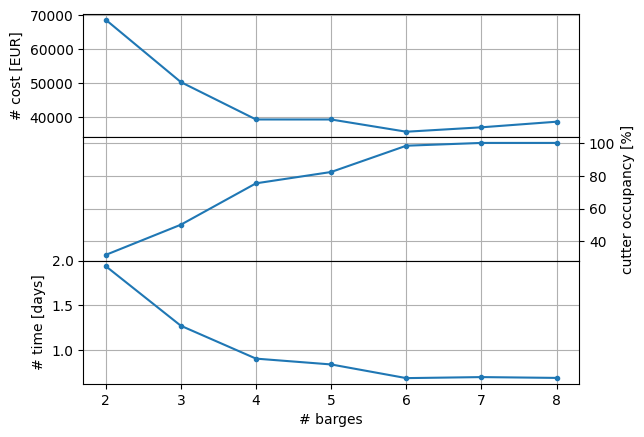

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True)


axs[0].plot(n_barges,cost,'.-'), axs[0].set_ylabel('# cost [EUR]'),axs[0].grid();
# axs[0].set_xlabel('# barges');

axs[1].plot(n_barges,occupancy,'.-'), axs[1].set_ylabel('cutter occupancy [%]'),axs[1].grid();
# axs[1].set_xlabel('# barges');
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()

axs[2].plot(n_barges,duration,'.-'), axs[2].set_ylabel('# time [days]'),axs[2].grid();

axs[-1].set_xlabel('# barges');

## Visualize critical path of best scneario

For explanation of Critical Path see notebook 30

In [13]:
from openclsim.plot.critical_path import CpLog

In [14]:
i = 5 # many barges: close to 100% cutter config, small cost, fast delivery
vessels = results[i]['vessels']
activities = results[i]['activities']
cutter = vessels[cutter_name]
to_site = results[i][to_site_name]
from_site = results[i][from_site_name]
  
my_objects = list(vessels.values()) + [from_site, to_site]
my_activities = list(activities.values())
my_log = CpLog(list_objects=my_objects, list_activities=my_activities)
dependencies = my_log.get_dependencies_model_based()
# dependencies = my_log.get_dependencies_log_based()
cp = my_log.mark_critical_activities(dependencies)
df = occupancy_analysis(vessels, cutter, activities,vessel_cost)
t = f'{cutter_name} occupancy: ' + str(df.loc[cutter_name]['occupancy [%]'])
fig = get_gantt_chart(concepts=my_objects, critical_path=cp, id_map=activities, title=t, legend=False, ylabel='vesels')

Occupancy "Cutter T": 100.0 % Total cost 36895.0
